In [90]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [91]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')

### Prepare Stock Data

In [92]:
# Display the stock data
stock_data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [93]:
# Assess the data types of the DataFrame
stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6300 non-null   object 
 1   Open        6300 non-null   float64
 2   High        6300 non-null   float64
 3   Low         6300 non-null   float64
 4   Close       6300 non-null   float64
 5   Adj Close   6300 non-null   float64
 6   Volume      6300 non-null   int64  
 7   Stock Name  6300 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.9+ KB


In [94]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Check for NaN and blank values in the DataFrame
blank_or_na_count = filtered_stock_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(blank_or_na_count)

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
dtype: int64


### Prepare Tweet Data

In [95]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [96]:
# Assess the data types of the DataFrame
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [97]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


In [98]:
# Check for NaN and blank values in the DataFrame
tweet_blank_or_na_count = filtered_tweet_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(tweet_blank_or_na_count)

Date          0
Stock Name    0
Tweet         0
dtype: int64


### Implement VADER Sentiment Analyzer on the Tweet data

In [99]:
# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)

filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.921,0.079,0.5040,Positive
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.071,0.905,0.024,-0.5106,Negative
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.745,0.255,0.9369,Positive


In [100]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'Compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.256980
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.256980
3,2021-09-30,PG,0.256980
4,2021-09-30,TSLA,0.251634
...,...,...,...
1763,2022-09-29,AMZN,0.086080
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.086080
1766,2022-09-29,PG,0.086080


In [101]:
# Merge the stock data and mean sentiment score DataFrames
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

merged_df = pd.merge(filtered_stock_data_df, mean_score_df, on=['Date', 'Stock Name'], how='inner').reset_index()

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis Label to the 'Mean Compound' column
merged_df['Sentiment'] = merged_df['Mean Compound'].apply(vader_sentiment_label)

merged_df = merged_df[['Date', 'Stock Name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mean Compound', 'Sentiment']]

merged_df

,Date,Stock Name,Open,High,Low,Close,Adj Close,Volume,Mean Compound,Sentiment
0,2021-09-30 00:00:00,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.251634,Positive
1,2021-10-01 00:00:00,TSLA,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.222412,Positive
2,2021-10-04 00:00:00,TSLA,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.151775,Positive
3,2021-10-05 00:00:00,TSLA,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.096692,Positive
4,2021-10-06 00:00:00,TSLA,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.229846,Positive
...,...,...,...,...,...,...,...,...,...,...
1222,2022-09-23 00:00:00,AMZN,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,0.050550,Positive
1223,2022-09-26 00:00:00,AMZN,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,-0.068714,Negative
1224,2022-09-27 00:00:00,AMZN,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,-0.186740,Negative
1225,2022-09-28 00:00:00,AMZN,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,0.418660,Positive


In [102]:
print(merged_df.head())
print(merged_df.shape)  # Check if it has any rows

                  Date Stock Name        Open        High         Low  \
0  2021-09-30 00:00:00       TSLA  260.333344  263.043335  258.333344   
1  2021-10-01 00:00:00       TSLA  259.466675  260.260010  254.529999   
2  2021-10-04 00:00:00       TSLA  265.500000  268.989990  258.706665   
3  2021-10-05 00:00:00       TSLA  261.600006  265.769989  258.066681   
4  2021-10-06 00:00:00       TSLA  258.733337  262.220001  257.739990   

        Close   Adj Close    Volume  Mean Compound Sentiment  
0  258.493347  258.493347  53868000       0.251634  Positive  
1  258.406677  258.406677  51094200       0.222412  Positive  
2  260.510010  260.510010  91449900       0.151775  Positive  
3  260.196655  260.196655  55297800       0.096692  Positive  
4  260.916656  260.916656  43898400       0.229846  Positive  
(1227, 10)


In [104]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Mapping the sentiment labels to numerical values
merged_df['Sentiment'] = merged_df['Sentiment'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Convert 'Date' to datetime format if not already in that format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort by date
merged_df = merged_df.sort_values('Date')

# Calculate the 60-day rolling average based on the 'Close' column and fill NaN values with 0
merged_df['60_day_moving_avg'] = merged_df['Close'].rolling(window=60).mean()
mean_value = merged_df[merged_df['60_day_moving_avg'] != 0]['60_day_moving_avg'].mean()
merged_df['60_day_moving_avg'] = merged_df['60_day_moving_avg'].replace(0, mean_value)

# Select only the relevant columns for LSTM (including target 'y' and regressors)
df_lstm = merged_df[['Close', 'Volume', 'Sentiment', '60_day_moving_avg']].dropna()

# Normalize the data (LSTMs benefit from normalized input)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Define the number of time steps (e.g., look back 60 days to predict the next day)
time_steps = 30

In [105]:
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i, :])  # The past `time_steps` days
        y.append(data[i, 0])  # The next day's stock price (target is 'y')
    return np.array(x), np.array(y)

# Prepare the sequences
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be 3D (samples, timesteps, features) as required by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# LSTM layer with 50 units, input shape = (timesteps, number of features)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer to predict the stock price
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
29/29 [==============================] - 4s 50ms/step - loss: 0.0887 - val_loss: 0.0532
Epoch 2/20
29/29 [==============================] - 1s 30ms/step - loss: 0.0642 - val_loss: 0.0526
Epoch 3/20
29/29 [==============================] - 1s 31ms/step - loss: 0.0614 - val_loss: 0.0529
Epoch 4/20
29/29 [==============================] - 1s 27ms/step - loss: 0.0619 - val_loss: 0.0527
Epoch 5/20
29/29 [==============================] - 1s 29ms/step - loss: 0.0618 - val_loss: 0.0522
Epoch 6/20
29/29 [==============================] - 1s 28ms/step - loss: 0.0605 - val_loss: 0.0536
Epoch 7/20
29/29 [==============================] - 1s 29ms/step - loss: 0.0597 - val_loss: 0.0535
Epoch 8/20
29/29 [==============================] - 1s 30ms/step - loss: 0.0598 - val_loss: 0.0536
Epoch 9/20
29/29 [==============================] - 1s 30ms/step - loss: 0.0591 - val_loss: 0.0516
Epoch 10/20
29/29 [==============================] - 1s 28ms/step - loss: 0.0599 - val_loss: 0.0550
Epoch 11/

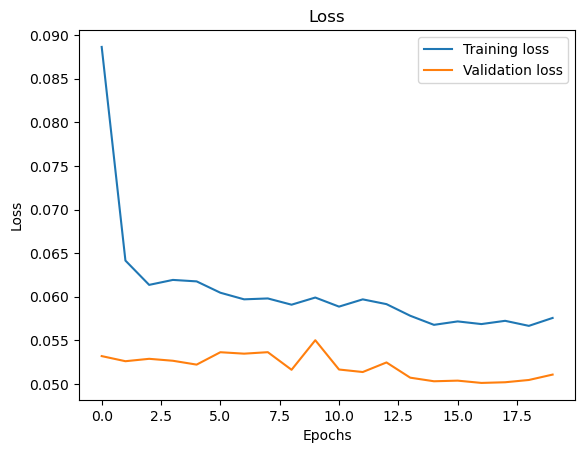

In [107]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Processing stock: TSLA
Epoch 1/20
5/5 - 4s - loss: 0.1141 - val_loss: 0.0044 - 4s/epoch - 820ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0463 - val_loss: 0.0049 - 275ms/epoch - 55ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0415 - val_loss: 0.0109 - 263ms/epoch - 53ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0390 - val_loss: 0.0076 - 276ms/epoch - 55ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0334 - val_loss: 0.0039 - 266ms/epoch - 53ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0274 - val_loss: 0.0043 - 288ms/epoch - 58ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0247 - val_loss: 0.0095 - 257ms/epoch - 51ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0204 - val_loss: 0.0049 - 249ms/epoch - 50ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0219 - val_loss: 0.0066 - 292ms/epoch - 58ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0222 - val_loss: 0.0073 - 296ms/epoch - 59ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0184 - val_loss: 0.0051 - 290ms/epoch - 58ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0186 - val_loss: 0.0052 - 272ms/epoch - 54ms/step
Epoch 13/20
5/5 

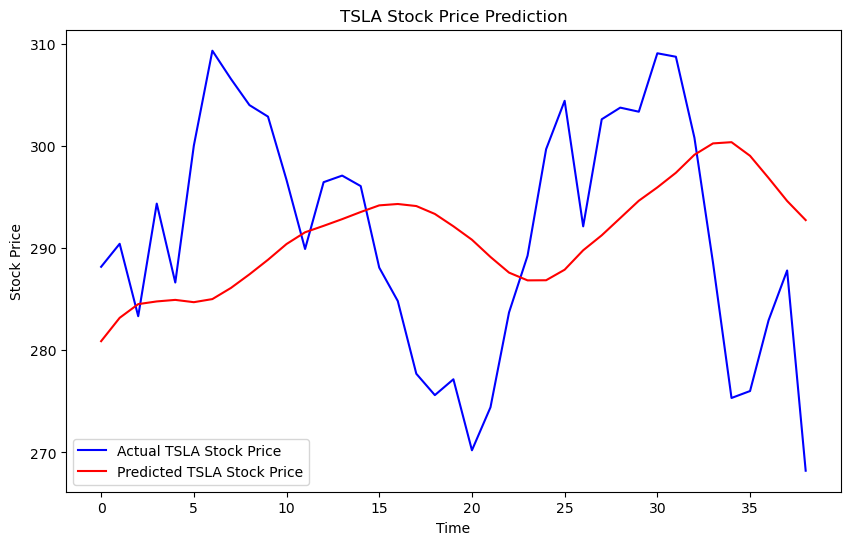

Processing stock: MSFT
Epoch 1/20
5/5 - 4s - loss: 0.0989 - val_loss: 0.1334 - 4s/epoch - 773ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0551 - val_loss: 0.0524 - 283ms/epoch - 57ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0346 - val_loss: 0.0265 - 270ms/epoch - 54ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0318 - val_loss: 0.0325 - 262ms/epoch - 52ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0227 - val_loss: 0.0452 - 290ms/epoch - 58ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0198 - val_loss: 0.0262 - 256ms/epoch - 51ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0166 - val_loss: 0.0193 - 269ms/epoch - 54ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0138 - val_loss: 0.0188 - 264ms/epoch - 53ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0168 - val_loss: 0.0190 - 277ms/epoch - 55ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0150 - val_loss: 0.0175 - 299ms/epoch - 60ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0153 - val_loss: 0.0169 - 280ms/epoch - 56ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0135 - val_loss: 0.0194 - 296ms/epoch - 59ms/step
Epoch 13/20
5/5 

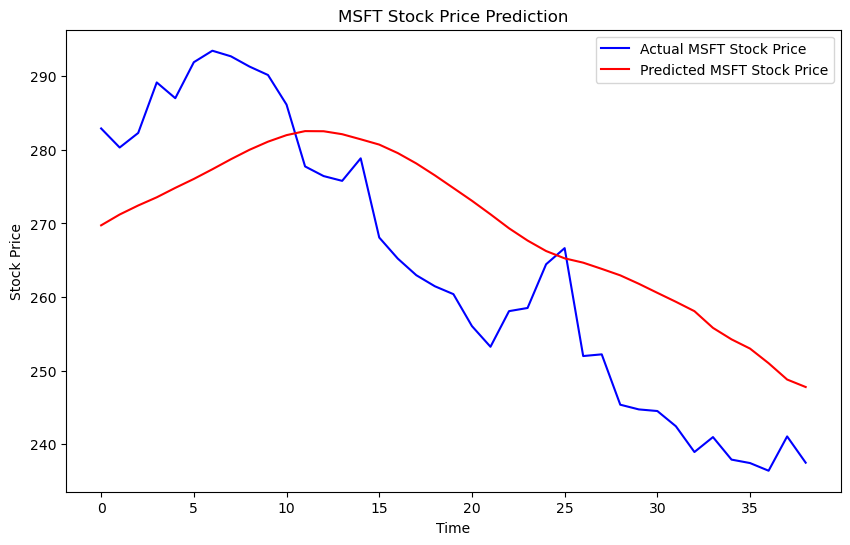

Processing stock: PG
Epoch 1/20
5/5 - 4s - loss: 0.2517 - val_loss: 0.1056 - 4s/epoch - 876ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0705 - val_loss: 0.1255 - 369ms/epoch - 74ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0359 - val_loss: 0.0353 - 309ms/epoch - 62ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0423 - val_loss: 0.0314 - 278ms/epoch - 56ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0339 - val_loss: 0.0635 - 328ms/epoch - 66ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0309 - val_loss: 0.0820 - 279ms/epoch - 56ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0281 - val_loss: 0.0492 - 294ms/epoch - 59ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0225 - val_loss: 0.0338 - 308ms/epoch - 62ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0278 - val_loss: 0.0401 - 292ms/epoch - 58ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0200 - val_loss: 0.0409 - 301ms/epoch - 60ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0190 - val_loss: 0.0306 - 332ms/epoch - 66ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0185 - val_loss: 0.0261 - 379ms/epoch - 76ms/step
Epoch 13/20
5/5 - 

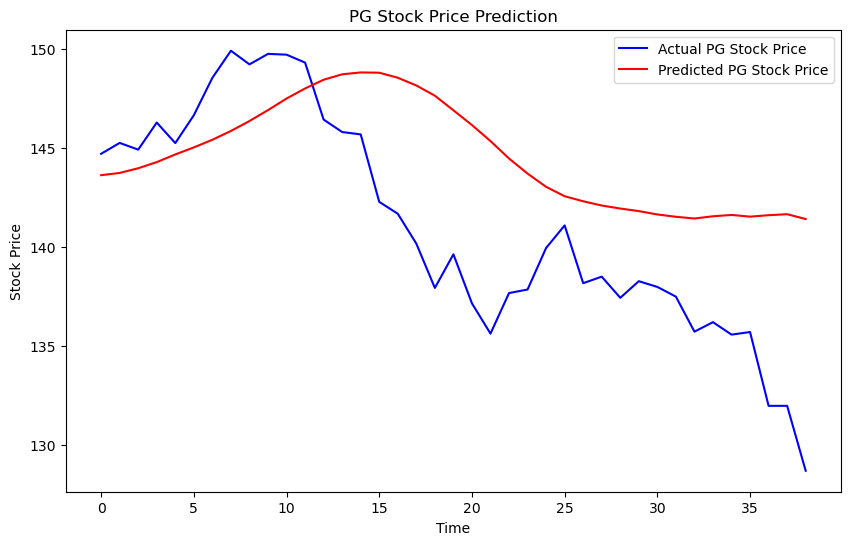

Processing stock: META
Epoch 1/20
4/4 - 4s - loss: 0.0982 - val_loss: 0.0921 - 4s/epoch - 902ms/step
Epoch 2/20
4/4 - 0s - loss: 0.0706 - val_loss: 0.0564 - 223ms/epoch - 56ms/step
Epoch 3/20
4/4 - 0s - loss: 0.0423 - val_loss: 0.0128 - 225ms/epoch - 56ms/step
Epoch 4/20
4/4 - 0s - loss: 0.0324 - val_loss: 0.0101 - 230ms/epoch - 57ms/step
Epoch 5/20
4/4 - 0s - loss: 0.0267 - val_loss: 0.0187 - 224ms/epoch - 56ms/step
Epoch 6/20
4/4 - 0s - loss: 0.0195 - val_loss: 0.0223 - 225ms/epoch - 56ms/step
Epoch 7/20
4/4 - 0s - loss: 0.0209 - val_loss: 0.0106 - 240ms/epoch - 60ms/step
Epoch 8/20
4/4 - 0s - loss: 0.0153 - val_loss: 0.0040 - 223ms/epoch - 56ms/step
Epoch 9/20
4/4 - 0s - loss: 0.0136 - val_loss: 0.0036 - 231ms/epoch - 58ms/step
Epoch 10/20
4/4 - 0s - loss: 0.0114 - val_loss: 0.0031 - 239ms/epoch - 60ms/step
Epoch 11/20
4/4 - 0s - loss: 0.0136 - val_loss: 0.0027 - 223ms/epoch - 56ms/step
Epoch 12/20
4/4 - 0s - loss: 0.0120 - val_loss: 0.0032 - 231ms/epoch - 58ms/step
Epoch 13/20
4/4 

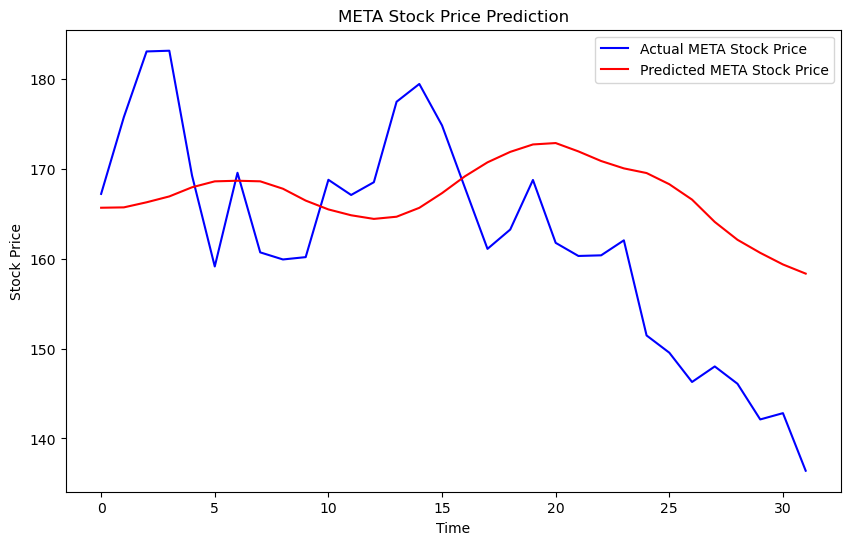

Processing stock: AMZN
Epoch 1/20
5/5 - 3s - loss: 0.1269 - val_loss: 0.0587 - 3s/epoch - 680ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0714 - val_loss: 0.0192 - 263ms/epoch - 53ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0509 - val_loss: 0.0122 - 266ms/epoch - 53ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0380 - val_loss: 0.0135 - 266ms/epoch - 53ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0295 - val_loss: 0.0134 - 264ms/epoch - 53ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0256 - val_loss: 0.0143 - 272ms/epoch - 54ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0218 - val_loss: 0.0109 - 260ms/epoch - 52ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0222 - val_loss: 0.0117 - 262ms/epoch - 52ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0175 - val_loss: 0.0087 - 258ms/epoch - 52ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0187 - val_loss: 0.0095 - 266ms/epoch - 53ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0172 - val_loss: 0.0097 - 275ms/epoch - 55ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0162 - val_loss: 0.0108 - 273ms/epoch - 55ms/step
Epoch 13/20
5/5 

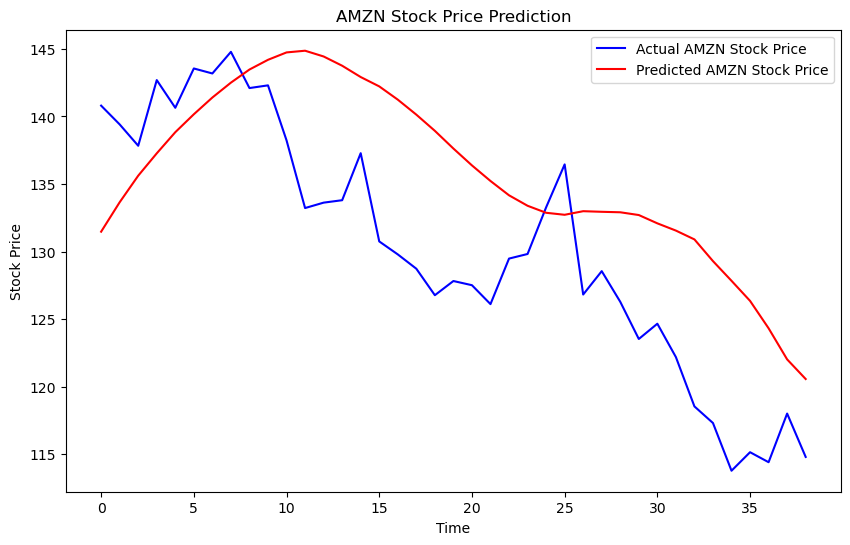

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Step 1: Sort by date
df = df.sort_values('ds')
# Calculate the 60-day rolling average based on the 'y' column (Close price)
df['60_day_moving_avg'] = df['y'].rolling(window=60).mean()
df['60_day_moving_avg'] = df['60_day_moving_avg'].fillna(0)

# Function to create sequences for LSTM
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i, :])  # The past `time_steps` days
        y.append(data[i, 0])  # The next day's stock price (target is 'y')
    return np.array(x), np.array(y)

# Define the number of time steps (e.g., look back 60 days to predict the next day)
time_steps = 60

# Loop through each stock in stock_names_of_interest
for stock in stock_names_of_interest:
    print(f"Processing stock: {stock}")
    
    # Step 2: Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock][['y', 'Volume', 'Sentiment', '60_day_moving_avg']].dropna()
    
    # Step 3: Normalize the data (LSTMs benefit from normalized input)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)
    
    # Step 4: Create sequences for LSTM
    X, y = create_sequences(scaled_data, time_steps)
    
    # Step 5: Split the data into training and testing sets (80% train, 20% test)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Step 6: Build the LSTM model
    model = Sequential()

    # First LSTM layer with Dropout
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Second LSTM layer with Dropout
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Dense output layer
    model.add(Dense(units=1))  # Single output for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Step 7: Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)
    
    # Step 8: Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions and actual values to get them back to the original scale
    predictions = scaler.inverse_transform(np.concatenate([predictions, X_test[:, -1, 1:]], axis=1))[:, 0]
    y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1))[:, 0]
    
    # Step 9: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, color='blue', label=f'Actual {stock} Stock Price')
    plt.plot(predictions, color='red', label=f'Predicted {stock} Stock Price')
    plt.title(f'{stock} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Processing stock: TSLA
Epoch 1/20
5/5 - 4s - loss: 0.1097 - val_loss: 0.0310 - 4s/epoch - 766ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0580 - val_loss: 0.0044 - 361ms/epoch - 72ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0401 - val_loss: 0.0106 - 292ms/epoch - 58ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0353 - val_loss: 0.0036 - 317ms/epoch - 63ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0309 - val_loss: 0.0060 - 301ms/epoch - 60ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0276 - val_loss: 0.0044 - 324ms/epoch - 65ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0226 - val_loss: 0.0054 - 293ms/epoch - 59ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0232 - val_loss: 0.0052 - 308ms/epoch - 62ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0220 - val_loss: 0.0054 - 317ms/epoch - 63ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0204 - val_loss: 0.0056 - 300ms/epoch - 60ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0185 - val_loss: 0.0053 - 304ms/epoch - 61ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0189 - val_loss: 0.0046 - 327ms/epoch - 65ms/step
Epoch 13/20
5/5 

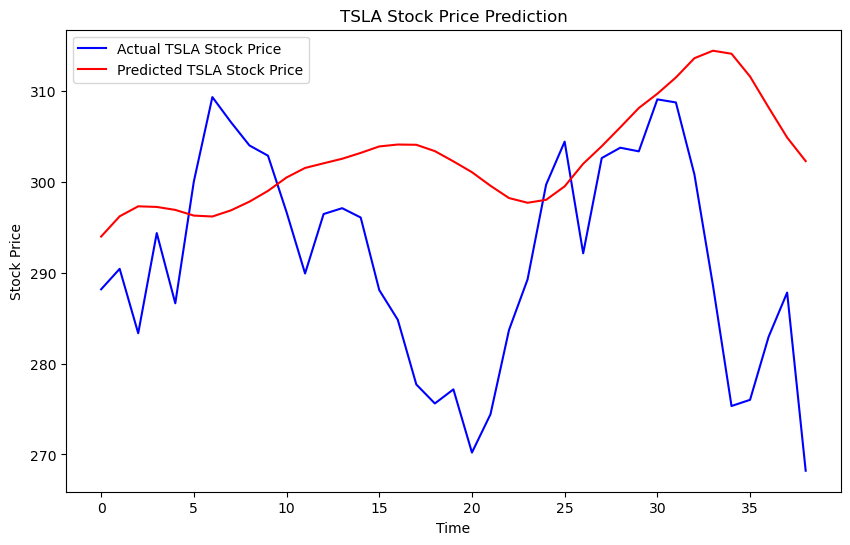

Processing stock: MSFT
Epoch 1/20
5/5 - 4s - loss: 0.1112 - val_loss: 0.1350 - 4s/epoch - 774ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0608 - val_loss: 0.0429 - 348ms/epoch - 70ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0327 - val_loss: 0.0208 - 308ms/epoch - 62ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0294 - val_loss: 0.0232 - 338ms/epoch - 68ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0206 - val_loss: 0.0348 - 309ms/epoch - 62ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0212 - val_loss: 0.0188 - 316ms/epoch - 63ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0169 - val_loss: 0.0163 - 317ms/epoch - 63ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0188 - val_loss: 0.0184 - 317ms/epoch - 63ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0153 - val_loss: 0.0156 - 317ms/epoch - 63ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0150 - val_loss: 0.0153 - 320ms/epoch - 64ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0147 - val_loss: 0.0182 - 327ms/epoch - 65ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0134 - val_loss: 0.0150 - 335ms/epoch - 67ms/step
Epoch 13/20
5/5 

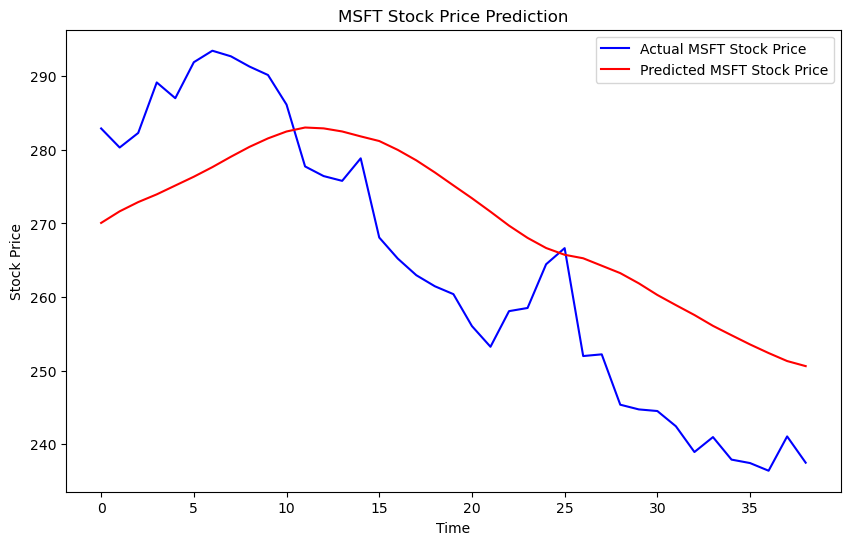

Processing stock: PG
Epoch 1/20
5/5 - 4s - loss: 0.1119 - val_loss: 0.1511 - 4s/epoch - 893ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0532 - val_loss: 0.0620 - 309ms/epoch - 62ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0356 - val_loss: 0.0290 - 293ms/epoch - 59ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0360 - val_loss: 0.0556 - 306ms/epoch - 61ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0314 - val_loss: 0.0675 - 301ms/epoch - 60ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0245 - val_loss: 0.0365 - 310ms/epoch - 62ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0209 - val_loss: 0.0317 - 300ms/epoch - 60ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0231 - val_loss: 0.0331 - 300ms/epoch - 60ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0173 - val_loss: 0.0252 - 300ms/epoch - 60ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0184 - val_loss: 0.0213 - 316ms/epoch - 63ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0154 - val_loss: 0.0173 - 311ms/epoch - 62ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0174 - val_loss: 0.0214 - 316ms/epoch - 63ms/step
Epoch 13/20
5/5 - 

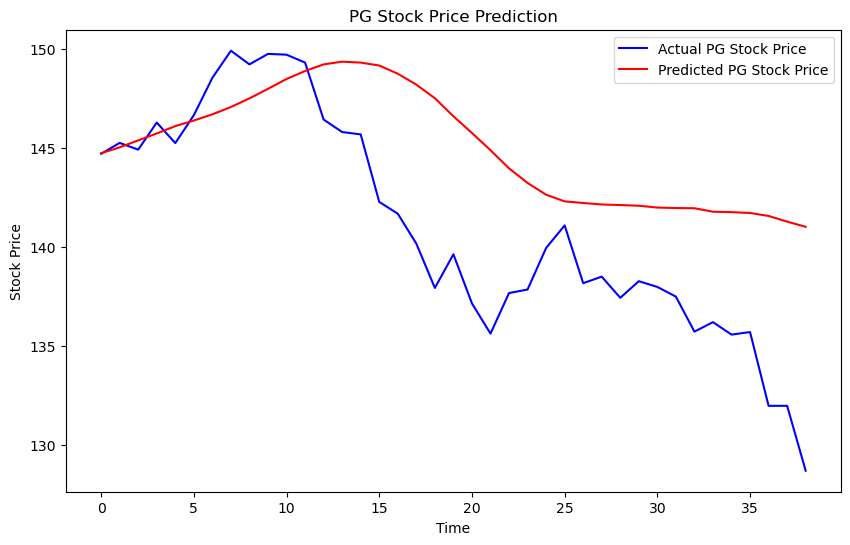

Processing stock: META
Epoch 1/20
4/4 - 4s - loss: 0.1182 - val_loss: 0.0731 - 4s/epoch - 932ms/step
Epoch 2/20
4/4 - 0s - loss: 0.0559 - val_loss: 0.0993 - 233ms/epoch - 58ms/step
Epoch 3/20
4/4 - 0s - loss: 0.0436 - val_loss: 0.0254 - 245ms/epoch - 61ms/step
Epoch 4/20
4/4 - 0s - loss: 0.0351 - val_loss: 0.0118 - 254ms/epoch - 63ms/step
Epoch 5/20
4/4 - 0s - loss: 0.0270 - val_loss: 0.0171 - 248ms/epoch - 62ms/step
Epoch 6/20
4/4 - 0s - loss: 0.0171 - val_loss: 0.0219 - 253ms/epoch - 63ms/step
Epoch 7/20
4/4 - 0s - loss: 0.0163 - val_loss: 0.0056 - 266ms/epoch - 66ms/step
Epoch 8/20
4/4 - 0s - loss: 0.0140 - val_loss: 0.0029 - 240ms/epoch - 60ms/step
Epoch 9/20
4/4 - 0s - loss: 0.0108 - val_loss: 0.0033 - 271ms/epoch - 68ms/step
Epoch 10/20
4/4 - 0s - loss: 0.0106 - val_loss: 0.0031 - 236ms/epoch - 59ms/step
Epoch 11/20
4/4 - 0s - loss: 0.0112 - val_loss: 0.0031 - 262ms/epoch - 66ms/step
Epoch 12/20
4/4 - 0s - loss: 0.0091 - val_loss: 0.0052 - 236ms/epoch - 59ms/step
Epoch 13/20
4/4 

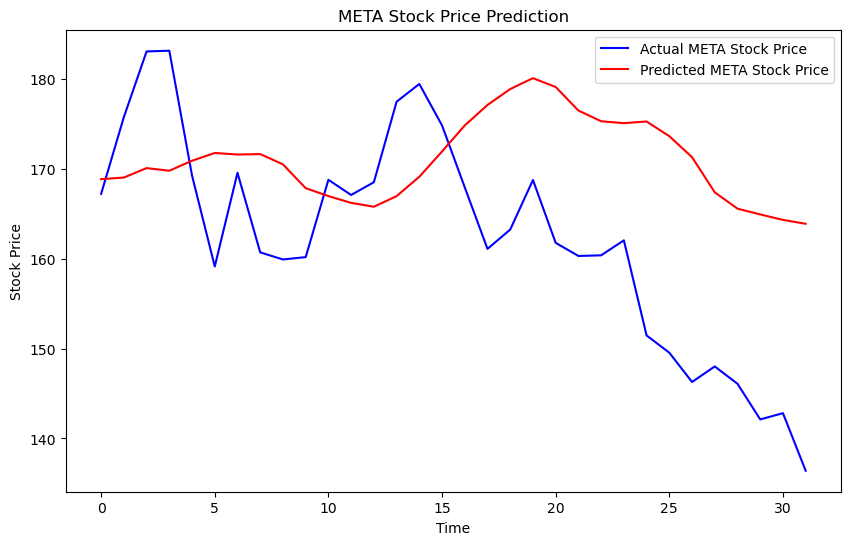

Processing stock: AMZN
Epoch 1/20
5/5 - 4s - loss: 0.1228 - val_loss: 0.0472 - 4s/epoch - 844ms/step
Epoch 2/20
5/5 - 0s - loss: 0.0518 - val_loss: 0.0138 - 285ms/epoch - 57ms/step
Epoch 3/20
5/5 - 0s - loss: 0.0384 - val_loss: 0.0099 - 286ms/epoch - 57ms/step
Epoch 4/20
5/5 - 0s - loss: 0.0303 - val_loss: 0.0123 - 286ms/epoch - 57ms/step
Epoch 5/20
5/5 - 0s - loss: 0.0252 - val_loss: 0.0108 - 287ms/epoch - 57ms/step
Epoch 6/20
5/5 - 0s - loss: 0.0217 - val_loss: 0.0113 - 300ms/epoch - 60ms/step
Epoch 7/20
5/5 - 0s - loss: 0.0201 - val_loss: 0.0109 - 310ms/epoch - 62ms/step
Epoch 8/20
5/5 - 0s - loss: 0.0193 - val_loss: 0.0099 - 287ms/epoch - 57ms/step
Epoch 9/20
5/5 - 0s - loss: 0.0211 - val_loss: 0.0114 - 302ms/epoch - 60ms/step
Epoch 10/20
5/5 - 0s - loss: 0.0173 - val_loss: 0.0104 - 298ms/epoch - 60ms/step
Epoch 11/20
5/5 - 0s - loss: 0.0191 - val_loss: 0.0084 - 300ms/epoch - 60ms/step
Epoch 12/20
5/5 - 0s - loss: 0.0168 - val_loss: 0.0156 - 310ms/epoch - 62ms/step
Epoch 13/20
5/5 

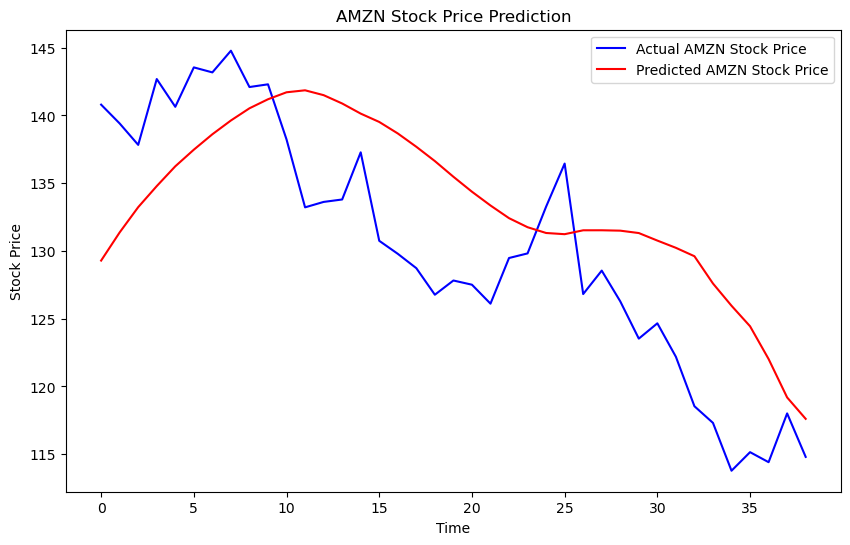

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Loop through each stock in stock_names_of_interest
for stock in stock_names_of_interest:
    print(f"Processing stock: {stock}")
    
    # Step 2: Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock][['y', 'Volume', 'Sentiment', '60_day_moving_avg']].dropna()
    
    # Step 3: Normalize the data (LSTMs benefit from normalized input)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)
    
    # Step 4: Create sequences for LSTM
    X, y = create_sequences(scaled_data, time_steps)
    
    # Step 5: Split the data into training and testing sets (80% train, 20% test)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Step 6: Build the LSTM model
    model = Sequential()

    # First LSTM layer with Dropout
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Second LSTM layer with Dropout
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Dense output layer
    model.add(Dense(units=1))  # Single output for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Step 7: Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)
    
    # Step 8: Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions and actual values to get them back to the original scale
    predictions = scaler.inverse_transform(np.concatenate([predictions, X_test[:, -1, 1:]], axis=1))[:, 0]
    y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1))[:, 0]
    
    # Step 9: Calculate performance metrics
    mae = mean_absolute_error(y_test_actual, predictions)
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, predictions)

    # Print the performance report
    print(f"Performance Report for {stock}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Step 10: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, color='blue', label=f'Actual {stock} Stock Price')
    plt.plot(predictions, color='red', label=f'Predicted {stock} Stock Price')
    plt.title(f'{stock} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
